<a href="https://colab.research.google.com/github/AndersieMichael/Thesis/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#initialisasi variable

mystate =32
imageSize = 224
epochs = 50
batch_size = 64
learningRate=0.001
weight_decay=0.0005

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import pandas as pd
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
# Ganti 'path_to_your_dataset' dengan path aktual ke folder dataset di Google Drive Anda
path_to_dataset = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/dataMerge'
# path_to_dataset = '/content/drive/MyDrive/Colab/deep learning/dataset/dataMerge'
train_dir = os.path.join(path_to_dataset, 'train')
test_dir = os.path.join(path_to_dataset, 'test')

files = os.listdir(path_to_dataset)
print(files)

Mounted at /content/drive
['train', 'train.cache', 'test', 'test.cache']


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype


In [ ]:
import torchvision.datasets as datasets

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
import matplotlib.pyplot as plt

def explore_dataset(dataset, dataset_directory, dataset_name):
    # Mendapatkan nama kelas dari dataset
    classes = dataset.classes

    # Menghitung jumlah gambar di setiap kelas
    class_counts = {}
    total_images = 0

    for class_name in classes:
        class_folder = os.path.join(dataset_directory, class_name)
        # Menghitung jumlah gambar dalam folder kelas
        num_images = len(os.listdir(class_folder))
        class_counts[class_name] = num_images
        total_images += num_images

    # Mencetak jumlah gambar di setiap kelas
    print(f"Jumlah gambar di setiap kelas untuk {dataset_name}:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} gambar")

    # Menghitung persentase untuk setiap kelas
    class_percentages = {class_name: (count / total_images) * 100 for class_name, count in class_counts.items()}

    # Memplot diagram donut untuk distribusi kelas secara keseluruhan
    plt.figure(figsize=(8, 8))
    plt.title(f"Class Distribution for {dataset_name}")
    plt.pie(class_percentages.values(), labels=class_percentages.keys(), autopct='%1.1f%%', startangle=90, colors=plt.cm.tab20.colors)
    # Menggambar lingkaran di tengah untuk membuatnya tampak seperti diagram donut
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    plt.gca().add_artist(centre_circle)

    plt.axis('equal')  # Rasio aspek yang sama memastikan pie digambar sebagai lingkaran.
    plt.show()


Jumlah gambar di setiap kelas untuk Train Dataset:
Acne: 138 gambar
Actinic Keratosis: 138 gambar
Basal Cell Carcinoma: 138 gambar
Eczemaa: 138 gambar
Rosacea: 138 gambar


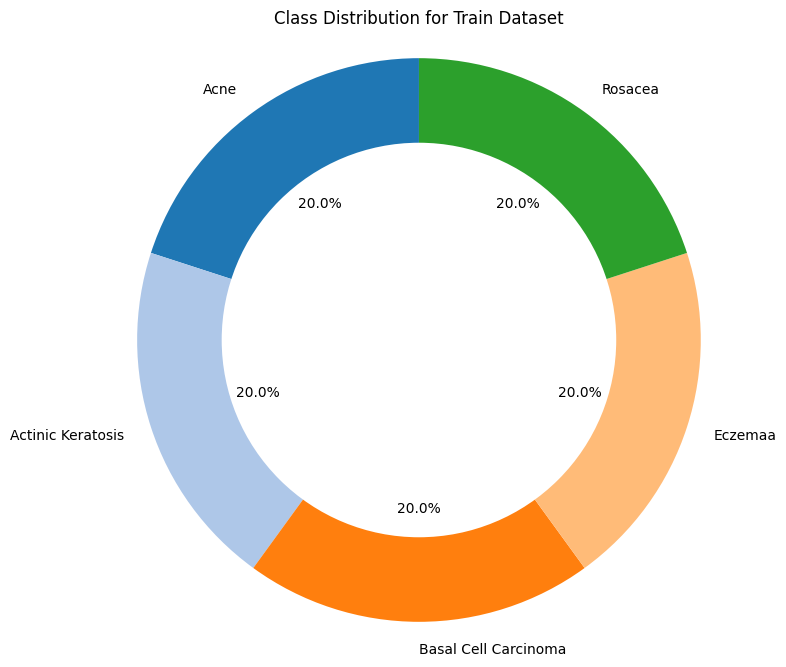

In [ ]:
# Eksplorasi untuk dataset pelatihan
explore_dataset(train_dataset, train_dir, 'Train Dataset')

Jumlah gambar di setiap kelas untuk Test Dataset:
Acne: 37 gambar
Actinic Keratosis: 37 gambar
Basal Cell Carcinoma: 37 gambar
Eczemaa: 37 gambar
Rosacea: 37 gambar


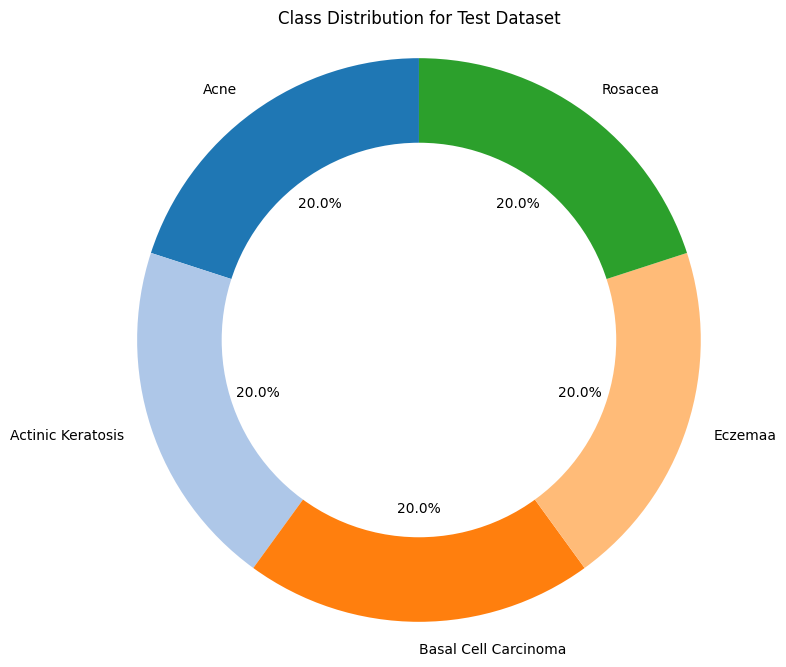

In [ ]:
# Eksplorasi untuk dataset pengujian
explore_dataset(test_dataset, test_dir, 'Test Dataset')

In [ ]:
# Periksa distribusi kelas
class_counts = {}
for _, label in train_dataset:
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

class_names = train_dataset.classes

# Cetak informasi distribusi kelas
for class_name, count in zip(class_names, class_counts.values()):
    print(f"Class: {class_name}, Number of images: {count}")

Class: Acne, Number of images: 138
Class: Actinic Keratosis, Number of images: 138
Class: Basal Cell Carcinoma, Number of images: 138
Class: Eczemaa, Number of images: 138
Class: Rosacea, Number of images: 138


In [ ]:
def optimizer_Setting(model):
        return torch.optim.Adam(model.parameters(), lr=learningRate,  weight_decay = weight_decay)


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Load the pretrained MobileNet V2 model
original_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Dummy input to calculate the output size
dummy_input = torch.zeros((1, 3, 224, 224))  # Assuming input size of 224x224

# Capture the size of features before flattening
with torch.no_grad():
    features_output = original_model.features(dummy_input)
    features_output = nn.AdaptiveAvgPool2d((1, 1))(features_output)
    num_features = features_output.view(-1).size(0)  # Flatten and get size

# Create a modified model to include dropout and the corrected transformation
class ModifiedMobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedMobileNetV2, self).__init__()
        self.features = original_model.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling to a fixed (1, 1) size
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Dropout layer
            nn.Flatten(),     # Flatten the output to 1D
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# Set the number of classes based on your dataset
num_classes = len(class_names)

# Instantiate the modified model
model = ModifiedMobileNetV2(num_classes)

# Freeze all layers except for the classifier
for param in model.features.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
optimizer = optimizer_Setting(model)

# Specify device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 219MB/s]


In [ ]:
from torchsummary import summary

In [ ]:
# Menggunakan mode eval dan menunjukkan summary model
model.eval()  # Ubah model ke mode evaluasi
summary(model, (3, 224, 224))  # 3 channel (RGB) dengan input ukuran 224x224

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [ ]:
# Tambahkan tracking metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
# Fungsi pelatihan
def train_model(model, criterion, optimizer, train_loader, test_loader,  save_path, num_epochs=15):
   # Early stopping dan saving best model
    best_loss = float('inf')
    patience = 10
    trigger_times = 0


    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backpropagation dan optimasi
            loss.backward()
            optimizer.step()

            # Statistik
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}')

        model.eval()
        val_loss, val_acc = validate(model, test_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        # Validasi dan cek early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f'Best model saved with loss: {best_loss:.4f}')
            trigger_times = 0
        else:
            trigger_times += 1
            print(f'No improvement in loss for {trigger_times} epochs')

        # if trigger_times >= patience:
        #     print('Early stopping triggered.')
        #     break

In [ ]:
def validate(model, test_loader):
    model.eval()  # Set model ke mode evaluasi
    running_loss = 0.0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()  # Definisikan kriteria loss

    with torch.no_grad():  # Nonaktifkan perhitungan gradien
        for inputs, labels in test_loader:  # Iterasi data dalam test_loader
            inputs, labels = inputs.to(device), labels.to(device)  # Transfer data ke device (GPU atau CPU)
            outputs = model(inputs)  # Dapatkan output dari model
            loss = criterion(outputs, labels)  # Hitung loss
            running_loss += loss.item() * inputs.size(0)  # Akumulasi loss

            # Prediksi dan hitung akurasi
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Hitung rata-rata loss dan akurasi
    avg_loss = running_loss / len(test_loader.dataset)
    accuracy = correct / total

    return avg_loss, accuracy

In [ ]:
mobileNetV2_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/pytorch code/mobileNetV2_best_model.pth'
# mobileNetV2_save_path = '/content/drive/MyDrive/Colab/deep learning/mobileNetV2_best_model.pth'

# Pelatihan dan pengujian model
train_model(model, criterion, optimizer, train_loader, test_loader, mobileNetV2_save_path, num_epochs=epochs)

Epoch 1/50, Train Loss: 1.5953, Train Accuracy: 0.2768
Epoch 1/50, Validation Loss: 1.3281, Validation Accuracy: 0.4811
Best model saved with loss: 1.3281
Epoch 2/50, Train Loss: 1.3523, Train Accuracy: 0.4594
Epoch 2/50, Validation Loss: 1.1408, Validation Accuracy: 0.6216
Best model saved with loss: 1.1408
Epoch 3/50, Train Loss: 1.2012, Train Accuracy: 0.5319
Epoch 3/50, Validation Loss: 1.0337, Validation Accuracy: 0.6703
Best model saved with loss: 1.0337
Epoch 4/50, Train Loss: 1.1177, Train Accuracy: 0.5768
Epoch 4/50, Validation Loss: 1.0098, Validation Accuracy: 0.6378
Best model saved with loss: 1.0098
Epoch 5/50, Train Loss: 1.0826, Train Accuracy: 0.5826
Epoch 5/50, Validation Loss: 0.9440, Validation Accuracy: 0.6811
Best model saved with loss: 0.9440
Epoch 6/50, Train Loss: 1.0211, Train Accuracy: 0.5899
Epoch 6/50, Validation Loss: 0.9310, Validation Accuracy: 0.6865
Best model saved with loss: 0.9310
Epoch 7/50, Train Loss: 0.9975, Train Accuracy: 0.6130
Epoch 7/50, Val

In [ ]:
import matplotlib.pyplot as plt

# Plotting with model name
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, model_name):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r-', label='Train Loss')
    plt.plot(epochs, val_losses, 'b-', label='Validation Loss')
    plt.title(f'Loss over epochs for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r-', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, 'b-', label='Validation Accuracy')
    plt.title(f'Accuracy over epochs for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

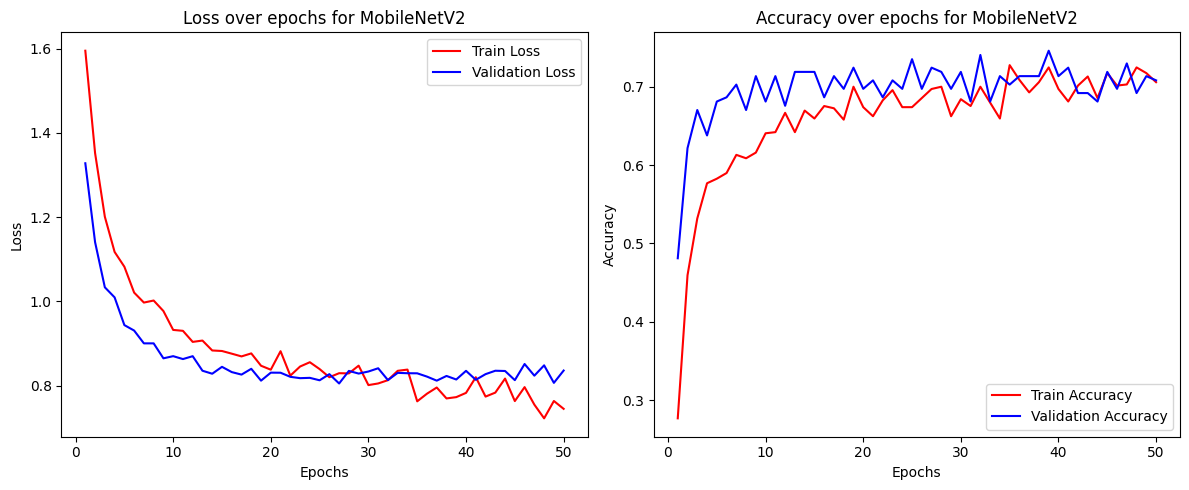

In [ ]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies,'MobileNetV2')

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# Load the pretrained MobileNet V3 Small model
original_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)

# Dummy input to calculate the output size
dummy_input = torch.zeros((1, 3, 224, 224))  # Assuming input size of 224x224

# Capture the size of features before flattening
with torch.no_grad():
    features_output = original_model.features(dummy_input)
    features_output = nn.AdaptiveAvgPool2d((1, 1))(features_output)
    num_features = features_output.view(-1).size(0)  # Flatten and get size

# Create a modified model to include dropout and the corrected transformation
class ModifiedMobileNetV3(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedMobileNetV3, self).__init__()
        self.features = original_model.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling to a fixed (1, 1) size
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Dropout layer
            nn.Flatten(),     # Flatten the output to 1D
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# Set the number of class based on your dataset
num_classes = len(class_names)

# Instantiate the modified model
model_v3_small = ModifiedMobileNetV3(num_classes)

# Freeze all layers except for the classifier
for param in model_v3_small.features.parameters():
    param.requires_grad = False
for param in model_v3_small.classifier.parameters():
    param.requires_grad = True

# Define the loss criterion and optimizer
criterion = nn.CrossEntropyLoss()

# Placeholder for your optimizer setting function
optimizer = optimizer_Setting(model_v3_small)

# Set the device and move the model to it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_v3_small = model_v3_small.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 173MB/s]


In [ ]:
# Menggunakan mode eval dan menunjukkan summary model
model_v3_small.eval()  # Ubah model ke mode evaluasi
summary(model_v3_small, (3, 224, 224))  # 3 channel (RGB) dengan input ukuran 224x224

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

In [ ]:
mobileNetV3_small_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/pytorch code/mobileNetV3_small_best_model.pth'
# mobileNetV3_small_save_path = '/content/drive/MyDrive/Colab/deep learning/mobileNetV3_small_best_model.pth'

# Tambahkan tracking metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# Pelatihan dan pengujian model
train_model(model_v3_small, criterion, optimizer, train_loader, test_loader, mobileNetV3_small_save_path, num_epochs=epochs)

Epoch 1/50, Train Loss: 1.6131, Train Accuracy: 0.2420
Epoch 1/50, Validation Loss: 1.5165, Validation Accuracy: 0.3568
Best model saved with loss: 1.5165
Epoch 2/50, Train Loss: 1.4909, Train Accuracy: 0.3536
Epoch 2/50, Validation Loss: 1.4167, Validation Accuracy: 0.5189
Best model saved with loss: 1.4167
Epoch 3/50, Train Loss: 1.3798, Train Accuracy: 0.4638
Epoch 3/50, Validation Loss: 1.3318, Validation Accuracy: 0.5351
Best model saved with loss: 1.3318
Epoch 4/50, Train Loss: 1.3122, Train Accuracy: 0.4884
Epoch 4/50, Validation Loss: 1.2834, Validation Accuracy: 0.5459
Best model saved with loss: 1.2834
Epoch 5/50, Train Loss: 1.2330, Train Accuracy: 0.5551
Epoch 5/50, Validation Loss: 1.2277, Validation Accuracy: 0.5514
Best model saved with loss: 1.2277
Epoch 6/50, Train Loss: 1.2020, Train Accuracy: 0.5232
Epoch 6/50, Validation Loss: 1.1834, Validation Accuracy: 0.5568
Best model saved with loss: 1.1834
Epoch 7/50, Train Loss: 1.1774, Train Accuracy: 0.5478
Epoch 7/50, Val

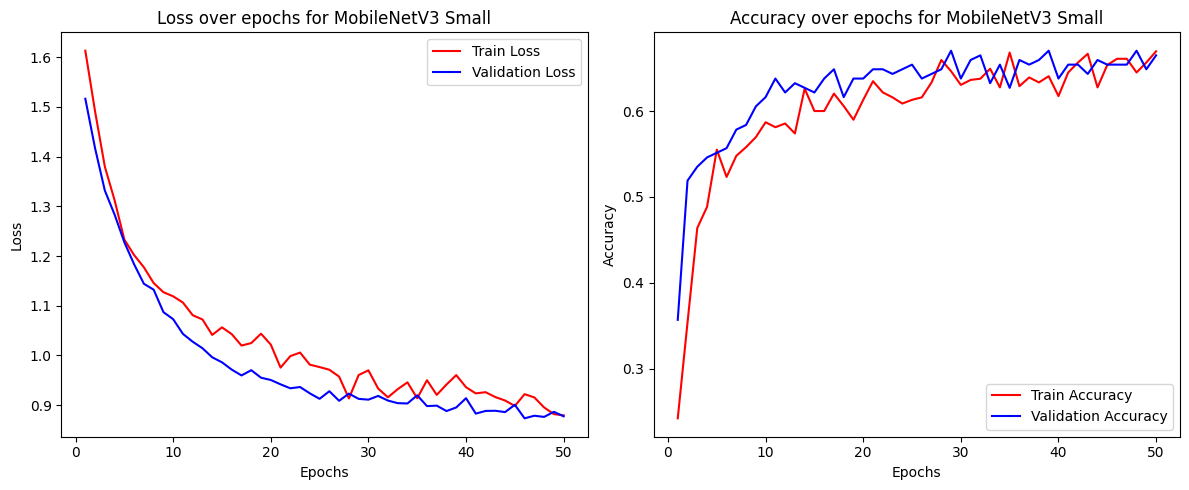

In [ ]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, 'MobileNetV3 Small')

In [ ]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

# Load pretrained MobileNet V3 large model
# model_v3_large = mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
# model_v3_large.classifier[3] = nn.Linear(model_v3_large.classifier[3].in_features,  len(class_names))  # Sesuaikan layer terakhir


# Load the pretrained MobileNet V3 Small model
original_model = mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)

# Dummy input to calculate the output size
dummy_input = torch.zeros((1, 3, 224, 224))  # Assuming input size of 224x224

# Capture the size of features before flattening
with torch.no_grad():
    features_output = original_model.features(dummy_input)
    features_output = nn.AdaptiveAvgPool2d((1, 1))(features_output)
    num_features = features_output.view(-1).size(0)  # Flatten and get size

# Create a modified model to include dropout and the corrected transformation
class ModifiedMobileNetV3(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedMobileNetV3, self).__init__()
        self.features = original_model.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling to a fixed (1, 1) size
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Dropout layer
            nn.Flatten(),     # Flatten the output to 1D
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# Set the number of class based on your dataset
num_classes = len(class_names)

# Instantiate the modified model
model_v3_large = ModifiedMobileNetV3(num_classes)

# Freeze all layers except for the classifier
for param in model_v3_large.features.parameters():
    param.requires_grad = False
for param in model_v3_large.classifier.parameters():
    param.requires_grad = True


# Kriteria dan optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_v3_large.parameters(), lr=learningRate)
optimizer = optimizer_Setting(model_v3_large)

# Tentukan device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_v3_large = model_v3_large.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 174MB/s]


In [ ]:
# Menggunakan mode eval dan menunjukkan summary model
model_v3_large.eval()  # Ubah model ke mode evaluasi
summary(model_v3_large, (3, 224, 224))  # 3 channel (RGB) dengan input ukuran 224x224

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

In [ ]:
mobileNetV3_large_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/pytorch code/mobileNetV3_large_best_model.pth'
# mobileNetV3_large_save_path = '/content/drive/MyDrive/Colab/deep learning/mobileNetV3_large_best_model.pth'
# Tambahkan tracking metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# Pelatihan dan pengujian model
train_model(model_v3_large, criterion, optimizer, train_loader, test_loader, mobileNetV3_large_save_path, num_epochs=epochs)

Epoch 1/50, Train Loss: 1.5644, Train Accuracy: 0.2812
Epoch 1/50, Validation Loss: 1.4745, Validation Accuracy: 0.4324
Best model saved with loss: 1.4745
Epoch 2/50, Train Loss: 1.3544, Train Accuracy: 0.4348
Epoch 2/50, Validation Loss: 1.3544, Validation Accuracy: 0.5027
Best model saved with loss: 1.3544
Epoch 3/50, Train Loss: 1.1919, Train Accuracy: 0.5362
Epoch 3/50, Validation Loss: 1.2591, Validation Accuracy: 0.5135
Best model saved with loss: 1.2591
Epoch 4/50, Train Loss: 1.1388, Train Accuracy: 0.5725
Epoch 4/50, Validation Loss: 1.1880, Validation Accuracy: 0.5351
Best model saved with loss: 1.1880
Epoch 5/50, Train Loss: 1.0578, Train Accuracy: 0.5942
Epoch 5/50, Validation Loss: 1.1376, Validation Accuracy: 0.5676
Best model saved with loss: 1.1376
Epoch 6/50, Train Loss: 1.0365, Train Accuracy: 0.5986
Epoch 6/50, Validation Loss: 1.0653, Validation Accuracy: 0.6108
Best model saved with loss: 1.0653
Epoch 7/50, Train Loss: 0.9735, Train Accuracy: 0.6391
Epoch 7/50, Val

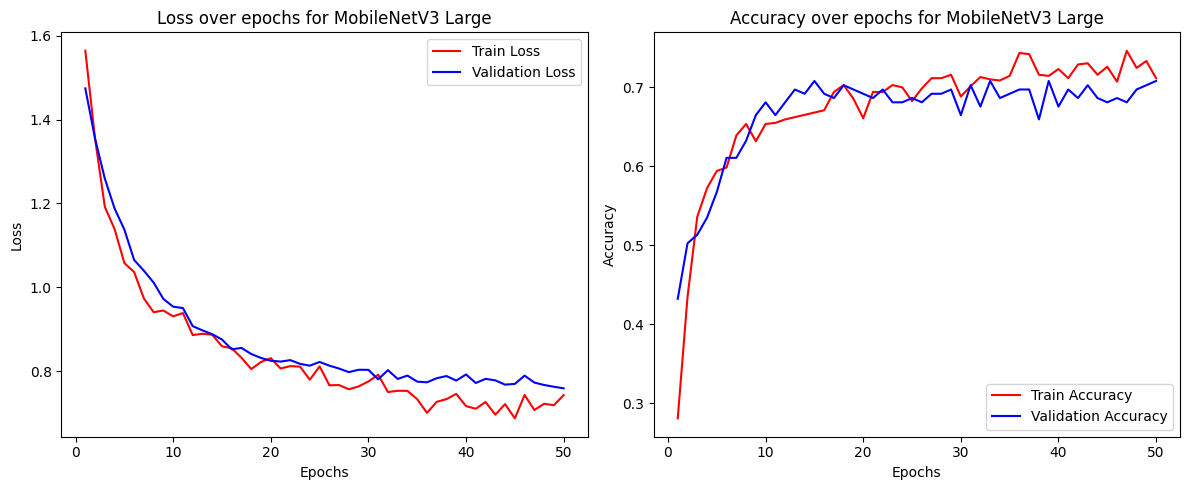

In [ ]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies,'MobileNetV3 Large')

In [ ]:
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

# Load pretrained EfficientNet B2 model
# model_efficientnet_b2 =

# Load the pretrained MobileNet V3 Small model
original_model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)

# Dummy input to calculate the output size
dummy_input = torch.zeros((1, 3, 224, 224))  # Assuming input size of 224x224

# Capture the size of features before flattening
with torch.no_grad():
    features_output = original_model.features(dummy_input)
    features_output = nn.AdaptiveAvgPool2d((1, 1))(features_output)
    num_features = features_output.view(-1).size(0)  # Flatten and get size

# Create a modified model to include dropout and the corrected transformation
class ModifiedEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedEfficientNet, self).__init__()
        self.features = original_model.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling to a fixed (1, 1) size
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Dropout layer
            nn.Flatten(),     # Flatten the output to 1D
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# Set the number of class based on your dataset
num_classes = len(class_names)

# Instantiate the modified model
model_efficientnet_b2 = ModifiedEfficientNet(num_classes)

# Freeze all layers except for the classifier
for param in model_efficientnet_b2.features.parameters():
    param.requires_grad = False
for param in model_efficientnet_b2.classifier.parameters():
    param.requires_grad = True


# Kriteria dan optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_efficientnet_b2.parameters(), lr=learningRate)
optimizer = optimizer_Setting(model_efficientnet_b2)

# Tentukan device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_efficientnet_b2 = model_efficientnet_b2.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 194MB/s]


In [ ]:
# Menggunakan mode eval dan menunjukkan summary model
model_efficientnet_b2.eval()  # Ubah model ke mode evaluasi
summary(model_efficientnet_b2, (3, 224, 224))  # 3 channel (RGB) dengan input ukuran 224x224

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [ ]:
efficientNet_b2_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/pytorch code/efficientNet_b2_best_model.pth'
# efficientNet_b2_save_path = '/content/drive/MyDrive/Colab/deep learning/efficientNet_b2_best_model.pth'

# Tambahkan tracking metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# Pelatihan dan pengujian model
train_model(model_efficientnet_b2, criterion, optimizer, train_loader, test_loader, efficientNet_b2_save_path, num_epochs=epochs)

Epoch 1/50, Train Loss: 1.5372, Train Accuracy: 0.3362
Epoch 1/50, Validation Loss: 1.4445, Validation Accuracy: 0.4973
Best model saved with loss: 1.4445
Epoch 2/50, Train Loss: 1.3774, Train Accuracy: 0.4768
Epoch 2/50, Validation Loss: 1.2780, Validation Accuracy: 0.5405
Best model saved with loss: 1.2780
Epoch 3/50, Train Loss: 1.2503, Train Accuracy: 0.5435
Epoch 3/50, Validation Loss: 1.1671, Validation Accuracy: 0.6216
Best model saved with loss: 1.1671
Epoch 4/50, Train Loss: 1.1738, Train Accuracy: 0.5928
Epoch 4/50, Validation Loss: 1.0921, Validation Accuracy: 0.6216
Best model saved with loss: 1.0921
Epoch 5/50, Train Loss: 1.1185, Train Accuracy: 0.6087
Epoch 5/50, Validation Loss: 1.0382, Validation Accuracy: 0.6324
Best model saved with loss: 1.0382
Epoch 6/50, Train Loss: 1.0436, Train Accuracy: 0.6507
Epoch 6/50, Validation Loss: 1.0034, Validation Accuracy: 0.6270
Best model saved with loss: 1.0034
Epoch 7/50, Train Loss: 1.0234, Train Accuracy: 0.6290
Epoch 7/50, Val

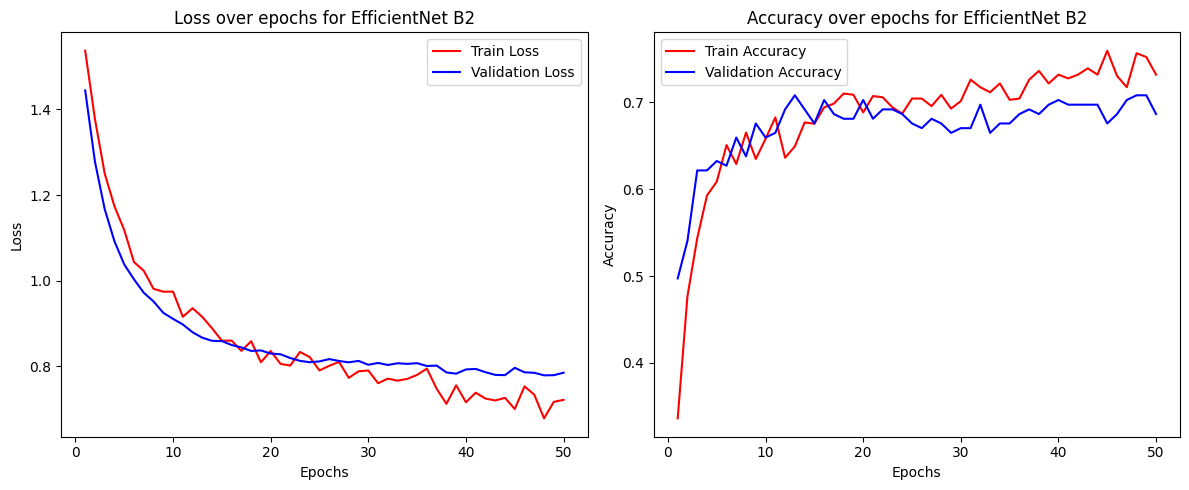

In [ ]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies,'EfficientNet B2')